## 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import torch
from torch import nn
from torch import optim

import torchvision.datasets as dset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from IPython import display

In [2]:
# DATA_ROOT = "../data/mnist"
DATA_ROOT = "../data/celeba"

# Number of workers for dataloader
WORKERS = 2

IMG_SIZE = 64 # 64

BATCH_SIZE = 64

NC = 3 # Number of channels in the training images. For color images this is 3
NZ = 100 # Size of z latent vector (i.e. size of generator input)

NGF = 64 # Size of feature maps in generator
NDF = 64 # Size of feature maps in discriminator

NGPU = 0 # Number of GPUs available. Use 0 for CPU mode.

LR = 0.0002 # Learning rate for optimizers

BETA1 = 0.5 # Beta1 hyperparam for Adam optimizers

EPOCHS = 10

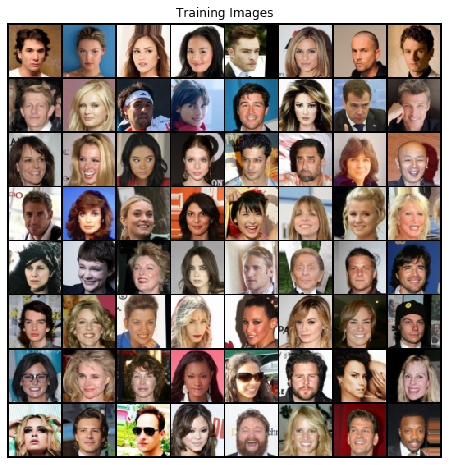

In [3]:
# CELEBRITY

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=DATA_ROOT,
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]) # Compose
) # ImageFolder

# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=WORKERS
) # DataLoader

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# # MNIST

# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         DATA_ROOT,
#         train=True,
#         download=False,
#         transform=transforms.Compose([
#             transforms.Resize(IMG_SIZE), 
#             transforms.ToTensor(), 
#             transforms.Normalize([0.5], [0.5])
#         ]), # Compose
#     ), # MINST
#     batch_size=BATCH_SIZE,
#     shuffle=True,
# ) # DataLoader

# real_batch = next(iter(dataloader))

# plt.figure(figsize=(8, 8))
# plt.axis('off')
# plt.imshow(
#     np.transpose(
#         make_grid(
#             real_batch[0][:64], 
#             padding=2, 
#             normalize=True
#         ), # make_grid
#     (1, 2, 0)
#     ) # transpose
# ) #imshow

# dataloader.dataset[0][0].shape

In [5]:
class Generator(nn.Module):
    def __init__(self, ncpu):
        super(Generator, self).__init__()
        self.ncpu = ncpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d(
                in_channels=NZ, # Количество каналов во входном изображении
                out_channels=NGF*8, # Количество каналов, созданных сверткой
                kernel_size=4, # Размер свертывающего ядра
                stride=1, # шаг свертки. По умолчанию: 1
                padding=0, # заполнение нулями будет добавлено к обеим сторонам каждого измерения во входных данных. 
                           # По умолчанию: 0, dilation * (kernel_size - 1) - padding
                bias=False # Если True, добавляет к выходным данным обучаемое смещение. Дефолт: True
            ), # ConvTranspose2d - Применяет двухмерный транспонированный оператор свертки к входному изображению, 
               # состоящему из нескольких входных плоскостей.
            nn.BatchNorm2d(num_features=NGF*8), # Применяет пакетную нормализацию к 4-мерному входу
            nn.ReLU(inplace=True), # Применяет функцию выпрямленного линейного блока поэлементно
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(in_channels=NGF*8, out_channels=NGF*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NGF*4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(in_channels=NGF*4, out_channels=NGF*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NGF*2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d(in_channels=NGF*2, out_channels=NGF, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NGF),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            
            nn.ConvTranspose2d(in_channels=NGF, out_channels=NC, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
            
        ) # Sequential - Последовательный контейнер.
    
    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
netG = Generator(NGPU)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (NC) x 64 x 64
            nn.Conv2d(
                in_channels=NC, out_channels=NDF, kernel_size=4, stride=2, padding=1, bias=False
            ), # Conv2d - Применяет двумерную свертку к входному сигналу, состоящему из нескольких входных плоскостей.
            nn.LeakyReLU(
                negative_slope=0.2, # Управляет углом отрицательного наклона. По умолчанию: 1e-2
                inplace=True
            ), # Применяет поэлементную функцию:
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=NDF, out_channels=NDF*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NDF*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=NDF*2, out_channels=NDF*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NDF*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=NDF*4, out_channels=NDF*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=NDF*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=NDF*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            
        ) # Sequential
        
    def forward(self, input):
        return self.main(input)

In [9]:
netD = Discriminator(NGPU)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, NZ, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

[9/10][781/782]	Loss_D: 0.6139	Loss_G: 5.2546	D(x): 0.8733	D(G(z)): 0.3342 / 0.0061


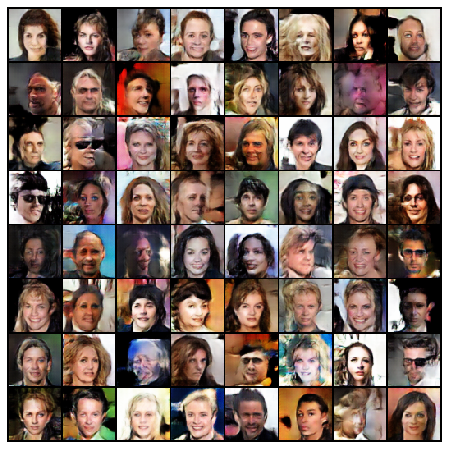

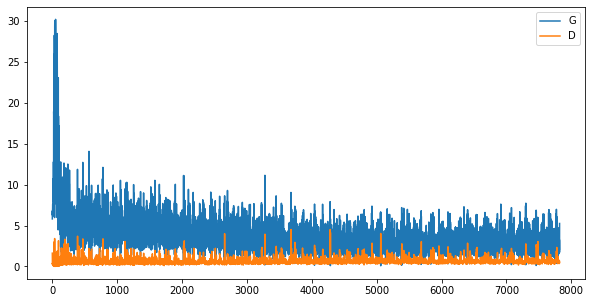

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# # For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NZ, 1, 1)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
#         if i % 50 == 0:
            
        display.clear_output(wait=False)

        print(
            f'[{epoch}/{EPOCHS}][{i}/{len(dataloader)}]'
            f'\tLoss_D: {round(errD.item(), 4)}\tLoss_G: {round(errG.item(), 4)}'
            f'\tD(x): {round(D_x, 4)}\tD(G(z)): {round(D_G_z1, 4)} / {round(D_G_z2, 4)}')
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = netG(fixed_noise).detach()
        
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.imshow(np.transpose(make_grid(fake, padding=2, normalize=True),(1,2,0)), animated=True)
            if iters % 100 == 0:
                plt.savefig(f'../data/results/celebs{iters}.png')
            
            iters += 1
            
            plt.figure(figsize=(10, 5))
            plt.plot(G_losses, label="G")
            plt.plot(D_losses, label="D")
            plt.legend()
            plt.show()

### Вывод:
В процессе обучения заметно влияние дискриминатора на генератор:
- когда точность генератора повышается и доходит до отметки примерно в 5 loss, дискриминатор начинает на это реагировать, после чего точность генератора сильно падает